# -PPO- ZERO - untrained baseline

In [1]:
import os, time, torch, numpy as np, random
from DQN.dqn_model_qr import QRDQN
from C4.connect4_env import Connect4Env
from PPO.actor_critic import ActorCritic
import matplotlib.pyplot as plt
from PPO.ppo_agent_eval import *

In [2]:
SEED = 666
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [4]:
policy = ActorCritic().to(DEVICE).eval()
# Small sanity: parameter count
n_params = sum(p.numel() for p in policy.parameters())
print(f"ZERO ActorCritic params: {n_params:,}")

# Quick check that bias prior is present
print("center-bias scale:", getattr(policy, "_init_center_bias_scale", None))

ZERO ActorCritic params: 112,120
center-bias scale: 0.002


logits: [-0.01383 -0.00267  0.00935 -0.00771  0.0064  -0.00755 -0.00872]
probs:  [0.14139 0.14298 0.1447  0.14226 0.14428 0.14228 0.14211]  argmax= 2


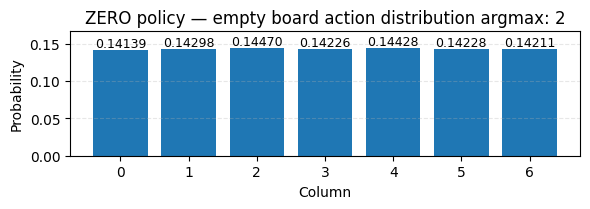

In [5]:
_ = plot_empty_board_action_distribution(policy, tag="ZERO policy")

In [6]:
# Cell 4: Symmetry self-test (mirroring should match after unflipping)
self_test(policy, atol=1e-2, n_random=32, rng_seed=0)

[SYM] max|q - mirror(q)| = 0.00510935
[CENTER] empty-board argmax = 2
[SYM] random-states: max=0.00660998, mean=0.00559831, >1e-05: 32/32
✅ PPO self-test passed.


In [7]:
# Cell 5: ZERO vs ZERO
A, B = policy, policy
n_games = 50
wins = draws = losses = 0
for g in range(n_games):
    A_color = +1 if (g % 2 == 0) else -1
    score = play_game_ppo(A, B, A_color=A_color, opening_noise_k=0, seed=SEED + g)
    if score == 1.0: wins += 1
    elif score == 0.5: draws += 1
    else: losses += 1

print(f"ZERO vs ZERO over {n_games}: W={wins} D={draws} L={losses}")


ZERO vs ZERO over 50: W=25 D=0 L=25


In [8]:
# Cell 6: ZERO vs a naive Random baseline
def random_act(env: Connect4Env) -> int:
    return int(random.choice(env.available_actions()))

def play_game_vs_random(policy: ActorCritic, policy_color: int=+1, seed: int=0) -> float:
    random.seed(seed); np.random.seed(seed)
    env = Connect4Env(); env.reset(); done = False
    while not done:
        mover = env.current_player
        if mover == policy_color:
            a = ppo_act_greedy(policy, env)
        else:
            a = random_act(env)
        _, _, done = env.step(a)
    if env.winner == 0: return 0.5
    return 1.0 if env.winner == policy_color else 0.0

n_games = 50
wins = draws = losses = 0
for g in range(n_games):
    policy_color = +1 if (g % 2 == 0) else -1
    res = play_game_vs_random(policy, policy_color=policy_color, seed=SEED + g)
    if res == 1.0: wins += 1
    elif res == 0.5: draws += 1
    else: losses += 1
print(f"ZERO vs Random over {n_games}: W={wins} D={draws} L={losses}")


ZERO vs Random over 50: W=37 D=0 L=13


In [9]:
model_filename = "ZERO PPO model.pt"

In [10]:
sd = policy.state_dict()
torch.save(sd, model_filename)

In [11]:
print(f"Saved: {model_filename}  ({os.path.getsize(model_filename)/1024:.1f} KB)")

Saved: ZERO PPO model.pt  (445.2 KB)
